In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [2]:
dados = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")

In [3]:
print("Tratamento da Base 1")

pacientes_UTI = dados[['PATIENT_VISIT_IDENTIFIER','ICU']].query('ICU == 1').groupby('PATIENT_VISIT_IDENTIFIER').min()
dados_tratados = dados.query('ICU != 1').drop('ICU', axis=1)
dados_tratados = dados_tratados.join(pacientes_UTI, on='PATIENT_VISIT_IDENTIFIER', how='left')
dados_tratados['ICU'] = dados_tratados['ICU'].fillna(0) 
print("\nRemovemos as linhas com ICU(UTI) igual a 1 e remarcamos a coluna com base no PATIENT_VISIT_IDENTIFIER que chegou na UTI")
print(f"Distribuição de ICU na base tratada (%)\n{dados_tratados['ICU'].value_counts(normalize=True)*100}")

features_continuas_colunas = dados_tratados.iloc[:, 13:-2].columns
features_continuas = dados_tratados.groupby("PATIENT_VISIT_IDENTIFIER",as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
features_categoricas = dados_tratados.iloc[:, :13]
saida = dados_tratados.iloc[:, -2:]
dados_tratados = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
dados_tratados.columns = dados.columns
print("\nAjustamos os valores continuos que estavam com Nam para o valor anterior ou posterior")

descricao = dados_tratados.describe().T
colunas_sem_variacao = descricao[descricao['min'] == descricao['max']].index
if len(colunas_sem_variacao) !=0:
  dados_tratados.drop(colunas_sem_variacao, axis=1)
  print("\nRemovemos as colunas que os valores são iguais para todas as linhas")

colunas_categoricas = list(set(dados_tratados.columns)-set(dados_tratados.describe().columns)-{'WINDOW'})
colunas_categoricas
if len(colunas_categoricas) ==1:
  LE = preprocessing.LabelEncoder()
  LE.fit(np.ravel(dados_tratados[colunas_categoricas]))
  dados_tratados[colunas_categoricas] = LE.transform(np.ravel(dados_tratados[colunas_categoricas]))
  print(f"\nColuna com objeto categórico ({colunas_categoricas[0]}) foi transformada em numérica")
else:
  print(f"\nColunas com objetos categóricos precisam ser tratados: {', '.join(colunas_categoricas)}")


linhas_com_nam = dados_tratados.describe(include='all').loc['count'].max()-dados_tratados.describe(include='all').loc['count'].min()
if linhas_com_nam !=0:
  if linhas_com_nam <= len(dados_tratados)*.1:
    dados_tratados.dropna(inplace=True)
    print(f"\nAs linhas ainda com Nam ({linhas_com_nam} linhas, {linhas_com_nam/len(dados_tratados):.2%} do total) foram eliminadas")
  else:
    print(f"\nTemos linhas ainda com Nam ({linhas_com_nam} linhas, {linhas_com_nam/len(dados_tratados):.2%} do total) precisam ser tratadas")

dados_tratados.reset_index(drop=True, inplace=True)
print(f"\nO index foi resetado: {dados_tratados.index}")

print(f"\nFormato final do DataFrame dados_tratados: {dados_tratados.shape}")

Tratamento da Base 1

Removemos as linhas com ICU(UTI) igual a 1 e remarcamos a coluna com base no PATIENT_VISIT_IDENTIFIER que chegou na UTI
Distribuição de ICU na base tratada (%)
0.0    67.375887
1.0    32.624113
Name: ICU, dtype: float64

Ajustamos os valores continuos que estavam com Nam para o valor anterior ou posterior

Removemos as colunas que os valores são iguais para todas as linhas

Coluna com objeto categórico (AGE_PERCENTIL) foi transformada em numérica

As linhas ainda com Nam (5.0 linhas, 0.36% do total) foram eliminadas

O index foi resetado: RangeIndex(start=0, stop=1405, step=1)

Formato final do DataFrame dados_tratados: (1405, 231)


In [4]:
print(f"Segunda Base Tratada")

age_percentil = np.array(dados_tratados['AGE_PERCENTIL']).reshape(-1, 1)
OHE = preprocessing.OneHotEncoder()
age_percentil_OHE = pd.DataFrame(OHE.fit_transform(age_percentil).toarray())
dados_tratados_OHE = pd.concat([dados_tratados.drop('AGE_PERCENTIL', axis=1), age_percentil_OHE], ignore_index=True, axis=1)
colunas = list(dados_tratados.columns)
colunas.remove('AGE_PERCENTIL')
colunas_novas = list(dados['AGE_PERCENTIL'].unique())
colunas_novas.sort()
colunas.extend(colunas_novas)
dados_tratados_OHE.columns = colunas
print(f"\nTrocamos o campo AGE_PERCENTIL pelos campos binários {', '.join(colunas_novas)}")

print(f"\nFormato final do DataFrame dados_tratados_OHE: {dados_tratados_OHE.shape}")

Segunda Base Tratada

Trocamos o campo AGE_PERCENTIL pelos campos binários 10th, 20th, 30th, 40th, 50th, 60th, 70th, 80th, 90th, Above 90th

Formato final do DataFrame dados_tratados_OHE: (1405, 240)


In [5]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

    np.random.seed(4367)
    dados = dados.sample(frac=1).reset_index(drop=True)
    y = dados["ICU"]
    x = dados.drop(["ICU","WINDOW","PATIENT_VISIT_IDENTIFIER"], axis=1)
    
    
    cv = RepeatedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(modelo, x, y, cv=cv, scoring='roc_auc')
    
    auc_medio = np.mean(resultados['test_score'])
    auc_std = np.std(resultados['test_score'])
    
 
    print(f"AUC Médio {auc_medio} Intervalo {auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)}")

In [6]:
def roda_modelo_stratified_cv(modelo, dados, n_splits, n_repeats):

    np.random.seed(4367)
    dados = dados.sample(frac=1).reset_index(drop=True)
    y = dados["ICU"]
    x = dados.drop(["ICU","WINDOW","PATIENT_VISIT_IDENTIFIER"], axis=1)
    
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(modelo, x, y, cv=cv, scoring='roc_auc')
    
    auc_medio = np.mean(resultados['test_score'])
    auc_std = np.std(resultados['test_score'])
    
 
    print(f"AUC Médio {auc_medio} Intervalo {auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)}")

In [7]:
roda_modelo_cv(LogisticRegression(max_iter=9000),dados_tratados.query('WINDOW == "0-2"'),5,10)

AUC Médio 0.7585856878805273 Intervalo 0.6728163048854148 - 0.8443550708756398


In [8]:
roda_modelo_stratified_cv(LogisticRegression(max_iter=9000),dados_tratados.query('WINDOW == "0-2"'),5,10)

AUC Médio 0.7571566931764301 Intervalo 0.6521306135217886 - 0.8621827728310716


In [38]:
dados_tratados.query('WINDOW == "0-2"').ICU.value_counts(normalize=True)

0.0    189
1.0    163
Name: ICU, dtype: int64

In [10]:
class modelos:
  def __init__(self, a, b, **kwargs):
    self.a = a
    self.b = b
  def metodo_a (self, c):
    return self.a*self.b*c

In [11]:
a = modelos(10,2)

In [12]:
a.metodo_a(1)

20

In [13]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 's

In [66]:
dicionario  = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
cv = RepeatedKFold(n_splits = 5, n_repeats=10)
y = dados_tratados["ICU"]
x = dados_tratados.drop(["ICU","WINDOW","PATIENT_VISIT_IDENTIFIER"], axis=1)
grid = GridSearchCV(LogisticRegression(max_iter=6000),dicionario, scoring="roc_auc",cv=cv,return_train_score=True)
resultados= grid.fit(x,y)

In [67]:
print('Melhor: %f usando %s' %(resultados.best_score_, resultados.best_params_))
means = resultados.cv_results_['mean_test_score']
stds = resultados.cv_results_['std_test_score']
params = resultados.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print(f'{mean:.3%} ({(mean-2*stdev):.3%} - {(mean+2*stdev):.3%}): {param}')

Melhor: 0.874238 usando {'solver': 'lbfgs'}
87.424% (82.996% - 91.852%): {'solver': 'newton-cg'}
87.424% (82.996% - 91.852%): {'solver': 'lbfgs'}
87.403% (83.001% - 91.804%): {'solver': 'liblinear'}
87.402% (83.001% - 91.803%): {'solver': 'sag'}
87.401% (83.000% - 91.802%): {'solver': 'saga'}


In [65]:
print(f'Melhor: {resultados_OHE.best_score_:.3%} usando {resultados_OHE.best_params_}')
means = resultados_OHE.cv_results_['mean_test_score']
stds = resultados_OHE.cv_results_['std_test_score']
params = resultados_OHE.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print(f'{mean:.3%} ({(mean-2*stdev):.3%} - {(mean+2*stdev):.3%}): {param}')

Melhor: 87.564% usando {'solver': 'newton-cg'}
87.564% (83.292% - 91.836%): {'solver': 'newton-cg'}
87.563% (83.292% - 91.834%): {'solver': 'lbfgs'}
87.529% (83.276% - 91.783%): {'solver': 'liblinear'}
87.529% (83.274% - 91.783%): {'solver': 'sag'}
87.529% (83.276% - 91.783%): {'solver': 'saga'}


In [68]:
resultados.__dict__

{'best_estimator_': LogisticRegression(max_iter=6000),
 'best_index_': 1,
 'best_params_': {'solver': 'lbfgs'},
 'best_score_': 0.8742378145349715,
 'cv': RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
 'cv_results_': {'mean_fit_time': array([0.14962143, 0.31480327, 0.08861282, 0.62619057, 1.20924917]),
  'mean_score_time': array([0.00825964, 0.00792744, 0.00793491, 0.00661498, 0.00704105]),
  'mean_test_score': array([0.87423761, 0.87423781, 0.87402662, 0.87402155, 0.87400666]),
  'mean_train_score': array([0.89888246, 0.8988787 , 0.89870421, 0.89868739, 0.89865311]),
  'param_solver': masked_array(data=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'solver': 'newton-cg'},
   {'solver': 'lbfgs'},
   {'solver': 'liblinear'},
   {'solver': 'sag'},
   {'solver': 'saga'}],
  'rank_test_score': array([2, 1, 3, 4, 5], dtype=int32),
  'split0_test_sco

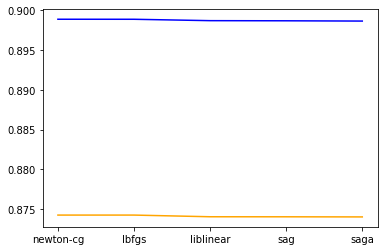

In [92]:
import matplotlib.pyplot as plt

x=[]
for item in resultados.cv_results_['params']:
  x.append(item['solver'])
plt.plot(x, resultados.cv_results_['mean_test_score'], color='orange')
plt.plot(x, resultados.cv_results_['mean_train_score'], color='blue')